# MSc Thesis - Hugo Stam

### Example 02 - Offshore Port System - Barges

<img src="Figures/system_layout_alternative_2B.png" style="width:1000px">

##### Investment Strategy Simulation - Adaptive terminal planning in the light of an uncertain future

* [**0. Prepare inputs:**](#0.-Prepare-inputs)<br>
   * [**0.1 Generate demand forecast scenario:**](#0.1-Generate-demand-forecast-scenario)<br>
   * [**0.2 Generate vessels:**](#0.2-Generate-vessels)<br>
* [**1. Instatiate system components:**](#1.-Instatiate-system-components)<br>
* [**2. Start simulation:**](#2.-Strart-simulation)<br>
* [**3. Report all elements:**](#3.-Report-all-elements)<br>

#### notes:


In [1]:
# packages for data handling
import numpy as np
import pandas as pd
import statistics as st

# packages for figures
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
# %matplotlib inline
%matplotlib notebook

import seaborn as sns
sns.set(style="ticks")
# sns.set_style("whitegrid")
# sns.set(style="darkgrid", palette = "pastel")
# sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.5})

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# OpenTISim package
from opentisim import container_objects
from opentisim import container_defaults
from opentisim import container_system_offshore_barge

# OpenCLSim package
import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

# Additional import to save the initialisation of the simulation
import openclsim.savesim as savesim

# Pretty-print a Python object to a stream
from pprint import pprint

# Jupyter Widgets
import ipywidgets as widgets
from IPython.display import HTML

# Scroll to specific cell
from jupyter_helpers.utilities import scroll_to_current_cell

# no warnings
import warnings
warnings.filterwarnings('ignore')

# 0. Prepare inputs

In [2]:
# scroll_to_current_cell(preserve=True)

In [3]:
# iPython Widgests
life_cycle = widgets.IntSlider(value=10, min=10, max=30, step=5, description='Life cycle:')
annual_demand = widgets.IntSlider(value=1000000, min=500000, max=1500000, step=50000, description='Demand:')
offshore_onshore_distance = widgets.IntSlider(value=40, min=20, max=60, step=20, description='Distance:')

container_ship = widgets.Dropdown(options=[('Post Panamax I (6,000 TEU)', 6000),
                                           ('New-Panamax (12,500 TEU)', 12500),
                                           ('ULCS (21,000 TEU)', 21000)], 
                                  value=12500, description='OGV:')

barge = widgets.Dropdown(options=[('Small (200 TEU)', 200), 
                                  ('Medium (250 TEU)', 250),
                                  ('Large (300 TEU)', 300)], 
                         value=250, description='Barge:')

print('\033[1m*** Input Values \033[0m')
display(annual_demand, offshore_onshore_distance, container_ship, barge, life_cycle)

*** Input Values 


IntSlider(value=1000000, description='Demand:', max=1500000, min=500000, step=50000)

IntSlider(value=40, description='Distance:', max=60, min=20, step=20)

Dropdown(description='OGV:', index=1, options=(('Post Panamax I (6,000 TEU)', 6000), ('New-Panamax (12,500 TEU…

Dropdown(description='Barge:', index=1, options=(('Small (200 TEU)', 200), ('Medium (250 TEU)', 250), ('Large …

IntSlider(value=10, description='Life cycle:', max=30, min=10, step=5)

In [4]:
offshore_distance = offshore_onshore_distance.value
demand = annual_demand.value
design_container_ship = container_ship.value
design_barge = barge.value
lifecycle = life_cycle.value

print('The offshore distance:', offshore_distance, 'km')
print('The annual demand:', demand, 'TEU')
print('The design container ship capacity:', design_container_ship, 'TEU')
print('The design barge capacity:', design_barge, 'TEU')
print('The design life cycle:', lifecycle, 'years')

avg_parcel = design_container_ship / 8

startyear = 2020

The offshore distance: 40 km
The annual demand: 1000000 TEU
The design container ship capacity: 12500 TEU
The design barge capacity: 250 TEU
The design life cycle: 10 years


## 0.1 Generate demand forecast scenario

11


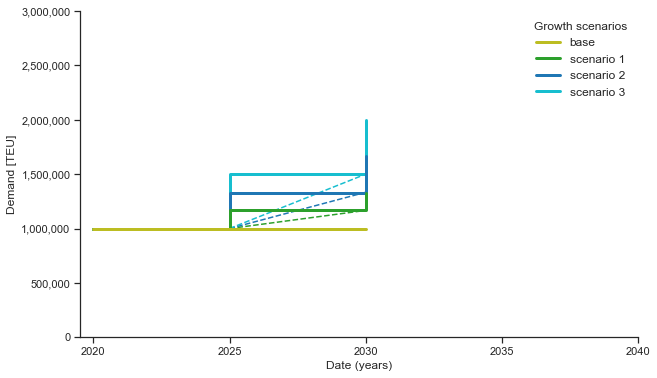

In [5]:
container = demand  # TEU
years = list(range(startyear, startyear+lifecycle+1))
print(len(years))
trend_1 = []
trend_2 = []
trend_3 = []

for i in range(lifecycle-4):
    trend_1.append(container +   500_000/15 * i)
    trend_2.append(container + 1_000_000/15 * i)
    trend_3.append(container + 1_500_000/15 * i)

demand_0 = []
demand_1 = []
demand_2 = []
demand_3 = []

for year in years:
    if year < 2025:
        demand_0.append(int(container * 1.00))
        demand_1.append(int(container * 1.00))
        demand_2.append(int(container * 1.00))
        demand_3.append(int(container * 1.00))
        
    elif year < 2030:
        demand_0.append(int(container * 1.00))
        demand_1.append(int(container * 1.17))
        demand_2.append(int(container * 1.33))
        demand_3.append(int(container * 1.50))
    elif year < 2035:
        demand_0.append(int(container * 1.00))
        demand_1.append(int(container * 1.33))
        demand_2.append(int(container * 1.67))
        demand_3.append(int(container * 2.00))
    else:
        demand_0.append(int(container * 1.00))
        demand_1.append(int(container * 1.50))
        demand_2.append(int(container * 2.00))
        demand_3.append(int(container * 2.50))

# figure 
plt.figure(figsize=(10,6))

plt.plot(years[5:lifecycle+1], trend_1, color='tab:green', linestyle='--', zorder=0)
plt.plot(years[5:lifecycle+1], trend_2, color='tab:blue' , linestyle='--', zorder=0)
plt.plot(years[5:lifecycle+1], trend_3, color='tab:cyan' , linestyle='--', zorder=0)

plt.step(years, demand_0, color='tab:olive', linewidth=3, label='base', where='post', zorder=4)
plt.step(years, demand_1, color='tab:green', linewidth=3, label='scenario 1', where='post', zorder=3)
plt.step(years, demand_2, color='tab:blue' , linewidth=3, label='scenario 2', where='post', zorder=2)
plt.step(years, demand_3, color='tab:cyan' , linewidth=3, label='scenario 3', where='post', zorder=1)

plt.xticks([2020, 2025, 2030, 2035, 2040])
plt.xlabel("Date (years)", fontsize='large')

plt.yticks([0, 0.5e6, 1e6, 1.5e6, 2e6, 2.5e6, 3e6],
           [0, '500,000', '1,000,000', '1,500,000', '2,000,000', '2,500,000', '3,000,000'])
plt.ylabel('Demand [TEU]', fontsize='large')

plt.legend(loc='best', title='Growth scenarios', title_fontsize='large', fontsize='large', frameon=False)

# figure aesthetics
plt.grid(False, which='major')
sns.despine(top=True)

# save fig
if life_cycle == 20:
    plt.savefig("SaveFigures/growth_scenarios.png")

In [6]:
if lifecycle == 20:
    years = years[0:20]
    demand_0 = demand_0[0:20]
    demand_1 = demand_1[0:20]
    demand_2 = demand_2[0:20]
    demand_3 = demand_3[0:20]
    
if lifecycle == 10:
    years = years[0:10]
    demand_0 = demand_0[0:10]
    demand_1 = demand_1[0:10]
    demand_2 = demand_2[0:10]
    demand_3 = demand_3[0:10]

print('Years: ', len(years), years)    
print('Demand:', len(demand_2), demand_2)

Years:  10 [2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029]
Demand: 10 [1000000, 1000000, 1000000, 1000000, 1000000, 1330000, 1330000, 1330000, 1330000, 1330000]


In [7]:
years = list(range(startyear, startyear + lifecycle))
        
scenario_data={'year': years, 'volume': demand_3}
print(scenario_data)

# instantiate Commodity objects, the inputs for the Commodity class
if design_container_ship == 6000:
    container_defaults.container_data['post_panamax_I_perc'] = 100
    container_defaults.container_data['new_panamax_perc'] = 0
    container_defaults.container_data['ULCS_perc'] = 0

if design_container_ship == 12500:
    container_defaults.container_data['post_panamax_I_perc'] = 0
    container_defaults.container_data['new_panamax_perc'] = 100
    container_defaults.container_data['ULCS_perc'] = 0
    
if design_container_ship == 21000:
    container_defaults.container_data['post_panamax_I_perc'] = 0
    container_defaults.container_data['new_panamax_perc'] = 0
    container_defaults.container_data['ULCS_perc'] = 100
    
# print(container_defaults.container_data)

# ladens
container = container_objects.Commodity(**container_defaults.container_data)
container.scenario_data = pd.DataFrame(data=scenario_data)
# print(container)
# print(container.scenario_data)

# combine
demand = [container]

{'year': [2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029], 'volume': [1000000, 1000000, 1000000, 1000000, 1000000, 1500000, 1500000, 1500000, 1500000, 1500000]}


## 0.2 Generate vessels

In [8]:
# instantiate vessels
fully_cellular = container_objects.Vessel(**container_defaults.fully_cellular_data)
panamax = container_objects.Vessel(**container_defaults.panamax_data)
panamax_max = container_objects.Vessel(**container_defaults.panamax_max_data)
post_panamax_I = container_objects.Vessel(**container_defaults.post_panamax_I_data)
post_panamax_II = container_objects.Vessel(**container_defaults.post_panamax_II_data)
new_panamax = container_objects.Vessel(**container_defaults.new_panamax_data)
VLCS = container_objects.Vessel(**container_defaults.VLCS_data)
ULCS = container_objects.Vessel(**container_defaults.ULCS_data)

vessels = [fully_cellular, panamax, panamax_max, post_panamax_I, post_panamax_II, new_panamax, VLCS, ULCS] 

# 1. Instatiate system components

## 1.1 Terminal system

Specify the variables

In [9]:
OffshoreBarge = container_system_offshore_barge.System(
                startyear = startyear,
                lifecycle = lifecycle,
                stack_equipment = 'rmg',
                laden_stack = 'rmg',
                elements = demand + vessels,
                crane_type_defaults = container_defaults.sts_crane_data,
                offshore_distance = offshore_distance,
                barge_type = 'medium',
                bathymetry_factor = 0.80,
                allowable_berth_occupancy = 0.70,
                laden_perc=0.80, 
                reefer_perc=0.10,
                empty_perc=0.05, 
                oog_perc=0.05,
                transhipment_ratio = 0.0,
                debug = True)

# 2. Start simulation

This method automatically generates investment decisions, parametrically derived from demand trends and a number of investment triggers.

Apply frame of reference style decisions while stepping through each year of the terminal lifecycle and check if investment is needed (in light of strategic objective, operational objective, QSC, decision recipe, intervention method):
    1. for each year evaluate the demand of each commodity (see 0.1 Demand forecast scenario)
    2. for each year evaluate the various investment decisions
    3. for each year calculate the energy costs (requires insight in realized demands)
    4. for each year calculate the demurrage costs (requires insight in realized demands)
    5. for each year calculate terminal revenues
    6. collect all cash flows (capex, opex, {revenues})
    7. calculate PV's {and aggregate to NPV}

In [10]:
OffshoreBarge.simulate()


Offshore Port System - Barge Connection

Below, the various investment decisions are evaluated for the year 2020.

Simulate year: 2020
  Total vessel calls: 640
  Fully cellular calls: 0
  Panamax calls: 0
  Panamax max calls: 0
  Post Panamax I calls: 0
  Post Panamax II calls: 0
  New Panamax calls: 640
  VLCS calls: 0
  ULCS calls: 0
  Total cargo volume: 1000000
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned

  Start analysis:
     Berth occupancy planned (@ start of year): inf
     Berth occupancy online  (@ start of year): inf
     Crane occupancy planned (@ start of year): inf
     Crane occupancy online  (@ start of year): inf

  *** add Berth to elements
     Berth occupancy planned (after adding Berth): inf
     Berth occupancy online  (after adding Berth): inf

*** nr of OGV berths: 1
     >> max vessel length: 366
     >> quay length 396 m
     >> quay depth 16 m
  *** add Quay

  *** add Empty Stack to elements
  *** add Empty Stack to elements
  *** add Empty Stack to elements
     OOG Slots planned  (@ start of year): 0
     OOG Slots online   (@ start of year): 0
     OOG Slots required (@ start of year): 551

  *** add OOG stack to elements
  *** add OOG stack to elements
  *** add OOG stack to elements
  *** add OOG stack to elements
  *** add OOG stack to elements
  *** add OOG stack to elements
     Total Ground Slots required   (@ start of year):  3,438
     Total Stack capacity required (@ start of year):  18,200 TEU
     Total Stack capacity online   (@ start of year):  0 TEU

     Number of stack Equipment online (@ start of year): 0

     Gate capacity planned     (@ start of year): 0
     Gate capacity online      (@ start of year): 0
     Gate service rate planned (@ start of year): inf
     Gate lane minutes         (@ start of year): 0

  *** add Gate to elements
  *** add Gate to elements
  *** add Gate to elements
  *** add Gate to elements


  *** add Empty Handler to elements
  *** add Empty Handler to elements
  *** add Empty Handler to elements
  *** add Empty Handler to elements
  *** add Empty Handler to elements
  *** add Empty Handler to elements
  *** add Empty Handler to elements
  *** add Empty Handler to elements
  *** add Empty Handler to elements
  *** add Empty Handler to elements
  *** add Empty Handler to elements
  *** add Empty Handler to elements
  *** add Empty Handler to elements
  *** add Empty Handler to elements
  *** add Empty Handler to elements
  *** add Empty Handler to elements
  *** add Empty Handler to elements
  *** add Empty Handler to elements
  *** add Empty Handler to elements
  *** add Empty Handler to elements
  *** add Empty Handler to elements
  *** add Empty Handler to elements
  *** add Empty Handler to elements
  *** add Empty Handler to elements
  *** add Empty Handler to elements
  *** add Empty Handler to elements
  *** add Empty Handler to elements
  *** add Empty Handler to e

  *** add Stack Equipment to elements
  *** add Stack Equipment to elements
  *** add Stack Equipment to elements
  *** add Stack Equipment to elements
  *** add Stack Equipment to elements
  *** add Stack Equipment to elements
  *** add Stack Equipment to elements
  *** add Stack Equipment to elements
  *** add Stack Equipment to elements
  *** add Stack Equipment to elements
  *** add Stack Equipment to elements
  *** add Stack Equipment to elements
  *** add Stack Equipment to elements
  *** add Stack Equipment to elements
  *** add Stack Equipment to elements
  *** add Stack Equipment to elements
  *** add Stack Equipment to elements
  *** add Stack Equipment to elements
     Gate capacity planned     (@ start of year): 540
     Gate capacity online      (@ start of year): 540
     Gate service rate planned (@ start of year): 0.976
     Gate lane minutes         (@ start of year): 527


     Offshore barge berth capacity planned     (@ start of year): 1082570.0 [TEU/yr]
     Offsho

     Berth occupancy planned (after adding Quay): 0.762
     Berth occupancy online  (after adding Quay): 0.925

  *** add STS crane to elements
     Berth occupancy planned (after adding Crane): 0.705
     Berth occupancy online  (after adding Crane): 0.925

*** nr of OGV berths: 4
  *** add STS crane to elements
     Berth occupancy planned (after adding Crane): 0.658
     Berth occupancy online  (after adding Crane): 0.925

length 366
draught 15.2
beam 49.0
quay_length 1000
quay_length 1000
     STS cranes online            (@ start of year): 7
     STS cranes planned           (@ start of year): 11
     Horizontal Transport online  (@ start of year): 35
     Horizontal Transport planned (@ start of year): 35
  *** add Tractor Trailer to elements
     a total of 35 tractor trailers is online; 1 tractor trailers still pending
  *** add Tractor Trailer to elements
     a total of 35 tractor trailers is online; 2 tractor trailers still pending
  *** add Tractor Trailer to elements
    

     Offshore barge berth capacity planned     (@ start of year): 1563705.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 1082565.0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1500000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.959

*** nr of offshore barge cranes: 12
  *** add Offshore Barge Crane to elements
*** nr of offshore barge cranes: 13
     Offshore barge berth capacity planned (after adding Crane): 1563710.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Crane): 1082570.0 [TEU/yr]

     Empty handlers planned (@ start of year): 35
  *** add Empty Handler to elements
  *** add Empty Handler to elements
  *** add Empty Handler to elements
  *** add Empty Handler to elements
  *** add Empty Handler to elements
  *** add Empty Handler to elements
  *** add Empty Handler to elements
  *** add Empty Handler to elements
  *** add Empty Handler to elements
  *** add Empt

throughput 1000000
vessel.year_online 2020
container_ship_costs 60,000,000 USD
throughput 1000000
vessel.year_online 2021
container_ship_costs 60,000,000 USD
throughput 1000000
vessel.year_online 2022
container_ship_costs 60,000,000 USD
throughput 1000000
vessel.year_online 2023
container_ship_costs 60,000,000 USD
throughput 1000000
vessel.year_online 2024
container_ship_costs 60,000,000 USD
throughput 1500000
vessel.year_online 2025
container_ship_costs 90,000,000 USD
throughput 1500000
vessel.year_online 2026
container_ship_costs 90,000,000 USD
throughput 1500000
vessel.year_online 2027
container_ship_costs 90,000,000 USD
throughput 1500000
vessel.year_online 2028
container_ship_costs 90,000,000 USD
throughput 1500000
vessel.year_online 2029
container_ship_costs 90,000,000 USD


,Years,Capex,Opex,PV,cum-PV
0,2020,-3.180000e+08,-6.988427e+08,-1.016843e+09,-1.016843e+09
1,2021,-4.498336e+08,-9.376084e+08,-1.387442e+09,-2.404285e+09
2,2022,-3.672522e+06,-1.230685e+08,-1.267410e+08,-2.531026e+09
3,2023,-3.463362e+06,-1.130204e+08,-1.164837e+08,-2.647509e+09
4,2024,-3.266115e+06,-1.037176e+08,-1.069838e+08,-2.754493e+09
5,2025,-3.080101e+06,-6.353078e+08,-6.383879e+08,-3.392881e+09
6,2026,-2.904681e+06,-3.031839e+08,-3.060886e+08,-3.698970e+09
7,2027,-2.739252e+06,-1.322506e+08,-1.349898e+08,-3.833959e+09
8,2028,-2.583244e+06,-1.213184e+08,-1.239017e+08,-3.957861e+09
9,2029,-2.436121e+06,-1.112026e+08,-1.136387e+08,-4.071500e+09


In [11]:
scroll_to_current_cell(preserve=True)

OffshoreBarge.summary(startyear + lifecycle)

Offshore-Onshore Port System

Offshore Terminal

Number of OGV berths: 4
Number of OGV quays walls: 4
Number of STS cranes: 11
Number of tractors: 55
Number of laden stacks: 19
Number of empty stacks: 9
Number of OOG stacks: 9
Number of stack equipment: 38
Number of barge berths: 13
Number of barge quay walls: 13
Number of barges cranes: 13

Onshore Terminal

Number of barge berths: 10
Number of barge quays: 10
Number of barges cranes: 10

Connection

Number of OGV channels: 1
Number of barge channels: 1
Number of reclamations: 1
Number of revetments: 1
Number of breakwaters: 1
Number of barges: 30


## 3. Report all elements

In [12]:
if True: 
    for element in OffshoreBarge.elements:
        print("")
        print(element.name)
        print("")
        print(element.__dict__) # This is the dictionary containing the module's symbol table.


Laden

{'historic_data': [], 'scenario_data':    year   volume
0  2020  1000000
1  2021  1000000
2  2022  1000000
3  2023  1000000
4  2024  1000000
5  2025  1500000
6  2026  1500000
7  2027  1500000
8  2028  1500000
9  2029  1500000, 'handling_fee': 150, 'fully_cellular_perc': 0, 'panamax_perc': 0, 'panamax_max_perc': 0, 'post_panamax_I_perc': 0, 'post_panamax_II_perc': 0, 'new_panamax_perc': 100, 'VLCS_perc': 0, 'ULCS_perc': 0, 'name': 'Laden', 'id': '6bd9d35e-6007-11ea-932d-0050b68868ee'}

Fully_Cellular_1

{'triggers': [], 'labour': [], 'maintenance': [], 'energy': [], 'insurance': [], 'fuel': [], 'demurrage': [], 'ocean_transport': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'structure_maintenance': [], 'barge_opex': [], 'barge_maintenace': [], 'truck_opex': [], 'truck_maintenace': [], 'off_terminal_capex': [], 'on_terminal_capex': [], 'capital_dredging': [], 'bridge_construction': [], 'island_construction': [], 'coastal_protection_construction': [], 'barge_capex': [


{'land_use': 2937.6, 'triggers': [], 'off_terminal_capex': 759400, 'on_terminal_capex': [], 'capital_dredging': [], 'bridge_construction': [], 'island_construction': [], 'coastal_protection_construction': [], 'barge_capex': [], 'truck_capex': [], 'labour': [], 'maintenance': 73440, 'energy': [], 'insurance': [], 'fuel': [], 'demurrage': [], 'ocean_transport': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'structure_maintenance': [], 'barge_opex': [], 'barge_maintenace': [], 'truck_opex': [], 'truck_maintenace': [], 'ownership': 'Terminal operator', 'delivery_time': 1, 'lifespan': 40, 'mobilisation': 25000, 'maintenance_perc': 0.1, 'width': 8, 'height': 6, 'length': 10, 'capacity': 480, 'gross_tgs': 18, 'area_factor': 2.04, 'pavement': 200, 'drainage': 50, 'household': 1.05, 'digout': 1.05, 'year_purchase': [], 'year_online': 2022, 'name': 'Empty Stack', 'id': '6c32ce4e-6007-11ea-90f2-0050b68868ee', 'storage_area': 1440.0, 'df':    Year  Offshore Terminal Capex  Onshore Ter


Barge_Berth

{'land_use': [], 'triggers': [], 'labour': [], 'maintenance': [], 'energy': [], 'insurance': [], 'fuel': [], 'demurrage': [], 'ocean_transport': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'structure_maintenance': [], 'barge_opex': [], 'barge_maintenace': [], 'truck_opex': [], 'truck_maintenace': [], 'off_terminal_capex': [], 'on_terminal_capex': [], 'capital_dredging': [], 'bridge_construction': [], 'island_construction': [], 'coastal_protection_construction': [], 'barge_capex': [], 'truck_capex': [], 'delivery_time': 2, 'max_cranes': 1.0, 'year_purchase': [], 'year_online': 2022, 'name': 'Barge_Berth', 'id': '6ca4e2bb-6007-11ea-80a5-0050b68868ee'}

Barge_Quay

{'land_use': 3900, 'triggers': [], 'renevue': [], 'labour': [], 'maintenance': 47197.8, 'energy': [], 'insurance': 47197.8, 'fuel': [], 'demurrage': [], 'ocean_transport': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'structure_maintenance': [], 'barge_opex': [], 'barge_maintenace': [], 


{'triggers': [], 'renevue': [], 'labour': 187500.0, 'maintenance': 100000.0, 'energy': [], 'insurance': 50000.0, 'fuel': [], 'demurrage': [], 'ocean_transport': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'structure_maintenance': [], 'barge_opex': [], 'barge_maintenace': [], 'truck_opex': [], 'truck_maintenace': [], 'off_terminal_capex': 5750000, 'on_terminal_capex': [], 'capital_dredging': [], 'bridge_construction': [], 'island_construction': [], 'coastal_protection_construction': [], 'barge_capex': [], 'truck_capex': [], 'ownership': 'Terminal operator', 'delivery_time': 1, 'lifespan': 40, 'unit_rate': 5000000, 'mobilisation_perc': 0.15, 'maintenance_perc': 0.02, 'insurance_perc': 0.01, 'consumption': 4, 'crew': 1.5, 'lifting_capacity': 1.6, 'avg_utilisation': 0.9, 'nom_crane_productivity': 15.0, 'utilisation': 0.9, 'efficiency': 0.75, 'handling_time_ratio': 0.9, 'peak_factor': 1.1, 'year_purchase': [], 'year_online': 2022, 'name': 'Barge Crane', 'id': '6cb04a76-6007-1


{'land_use': 38400.0, 'triggers': [], 'renevue': [], 'labour': [], 'maintenance': 464716.8, 'energy': [], 'insurance': 464716.8, 'fuel': [], 'demurrage': [], 'ocean_transport': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'structure_maintenance': [], 'barge_opex': [], 'barge_maintenace': [], 'truck_opex': [], 'truck_maintenace': [], 'off_terminal_capex': 52271680, 'on_terminal_capex': [], 'capital_dredging': [], 'bridge_construction': [], 'island_construction': [], 'coastal_protection_construction': [], 'barge_capex': [], 'truck_capex': [], 'year_purchase': [], 'year_online': 2027, 'ownership': 'Terminal operator', 'delivery_time': 2, 'lifespan': 50, 'mobilisation_min': 1000000, 'mobilisation_perc': 0.02, 'maintenance_perc': 0.01, 'insurance_perc': 0.01, 'berthing_gap': 15, 'freeboard': 4, 'Gijt_constant': 753.24, 'Gijt_coefficient': 1.2729, 'max_sinkage': 0.5, 'wave_motion': 0.5, 'safety_margin': 0.5, 'apron_width': 30, 'apron_pavement': 125, 'name': 'Barge_Quay', 'id': 

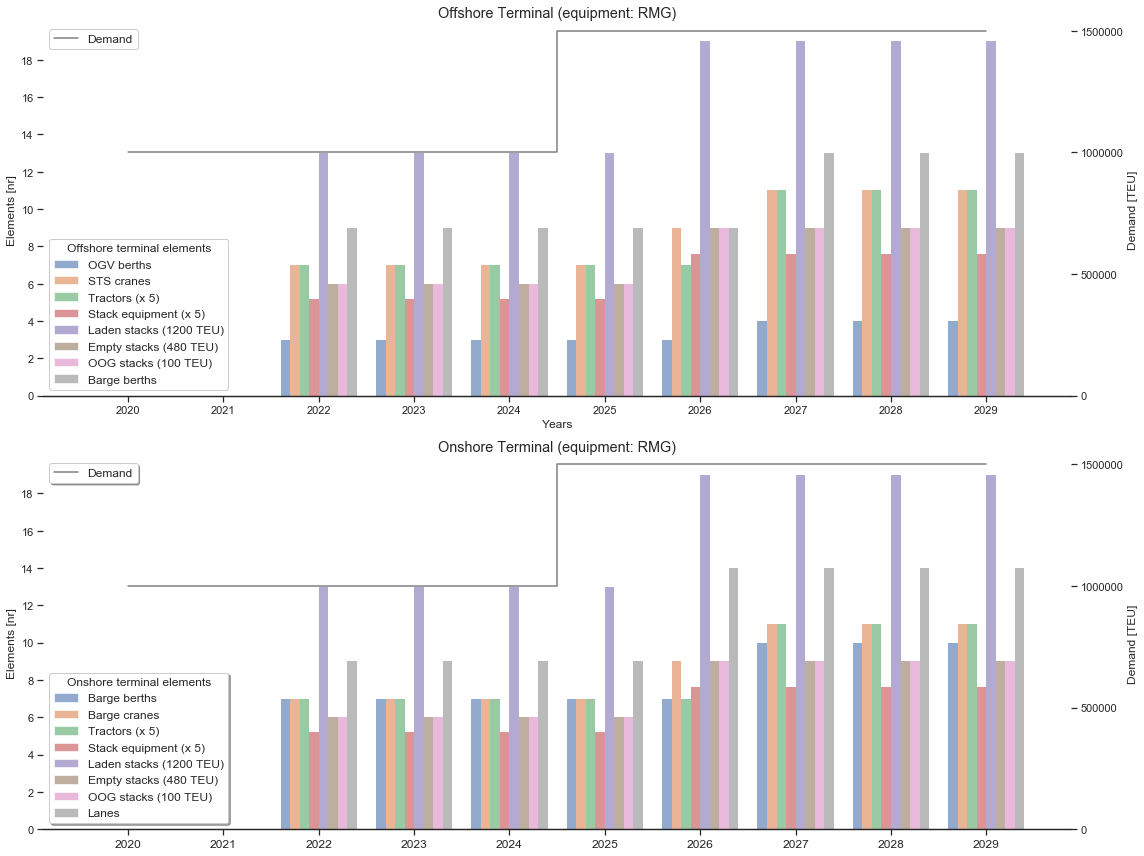

In [13]:
OffshoreBarge.terminal_elements_plot()
sns.despine(left=True)
# print(scenario_data)

# save fig
if lifecycle == 10:
    plt.savefig("SaveFigures/terminal_elements_alt2_example.png", bbox_inches = 'tight')
if lifecycle == 20:
    plt.savefig("SaveFigures/terminal_elements_alt2.png", bbox_inches = 'tight')

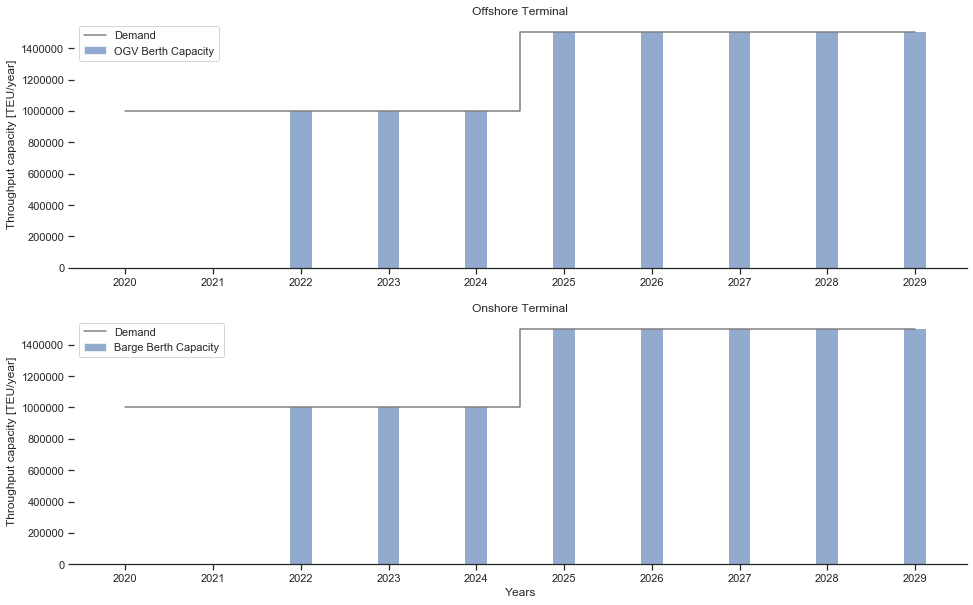

In [14]:
OffshoreBarge.terminal_capacity_plot()
sns.despine(left=True)

,Laden stack (ha),OOG stack (ha),Empty stack (ha),Total storage (ha),Total land use (ha)
Year,,,,,
2020,0.000000,0.000,0.00000,0.000000,0.000000
2021,0.000000,0.000,0.00000,0.000000,0.000000
2022,16.251862,4.032,1.76256,22.046422,56.770247
2023,16.251862,4.032,1.76256,22.046422,56.770247
2024,16.251862,4.032,1.76256,22.046422,56.770247
2025,16.251862,4.032,1.76256,22.046422,56.770247
2026,23.752721,6.048,2.64384,32.444561,67.168386
2027,23.752721,6.048,2.64384,32.444561,95.884056
2028,23.752721,6.048,2.64384,32.444561,95.884056


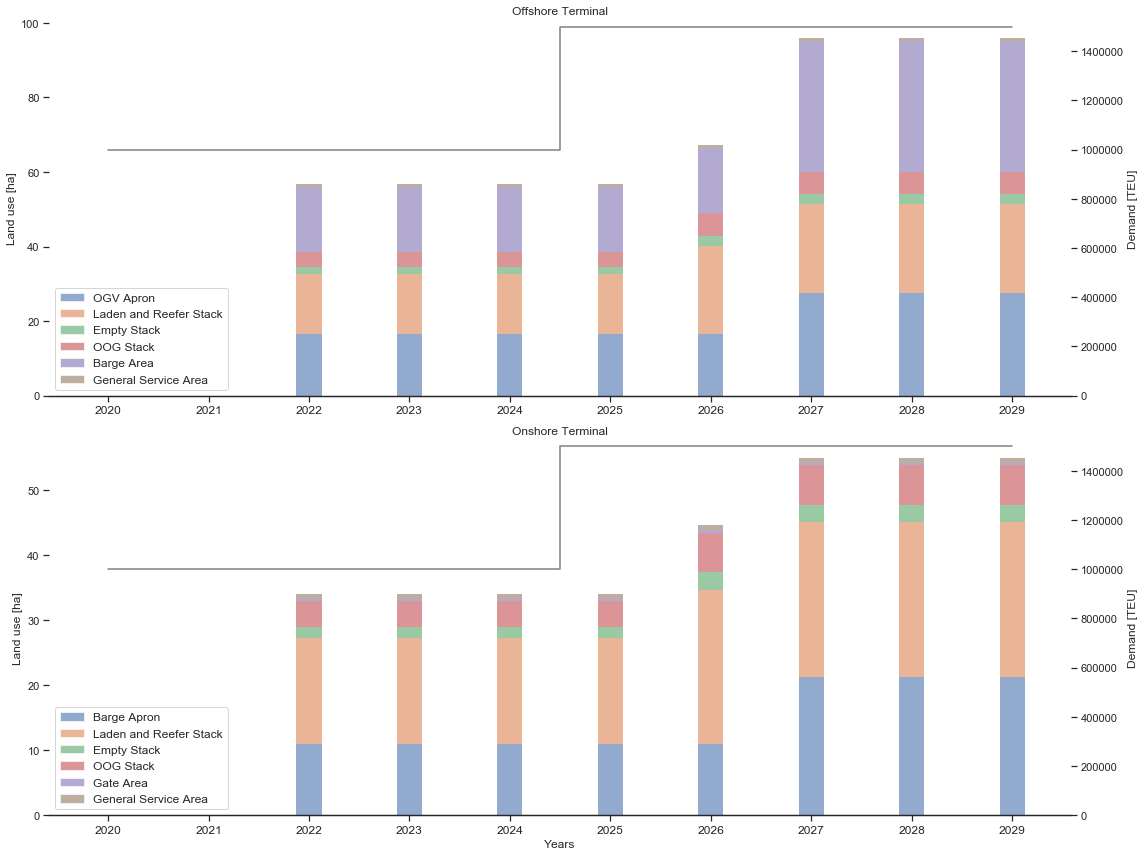

In [15]:
OffshoreBarge.terminal_land_use_plot()
sns.despine(left=True)

,Laden storage (TEU),Empty storage (TEU),OOG storage (TEU),Total storage (TEU)
Year,,,,
2020,0,0,0,0
2021,0,0,0,0
2022,15600,2880,600,19080
2023,15600,2880,600,19080
2024,15600,2880,600,19080
2025,15600,2880,600,19080
2026,22800,4320,900,28020
2027,22800,4320,900,28020
2028,22800,4320,900,28020


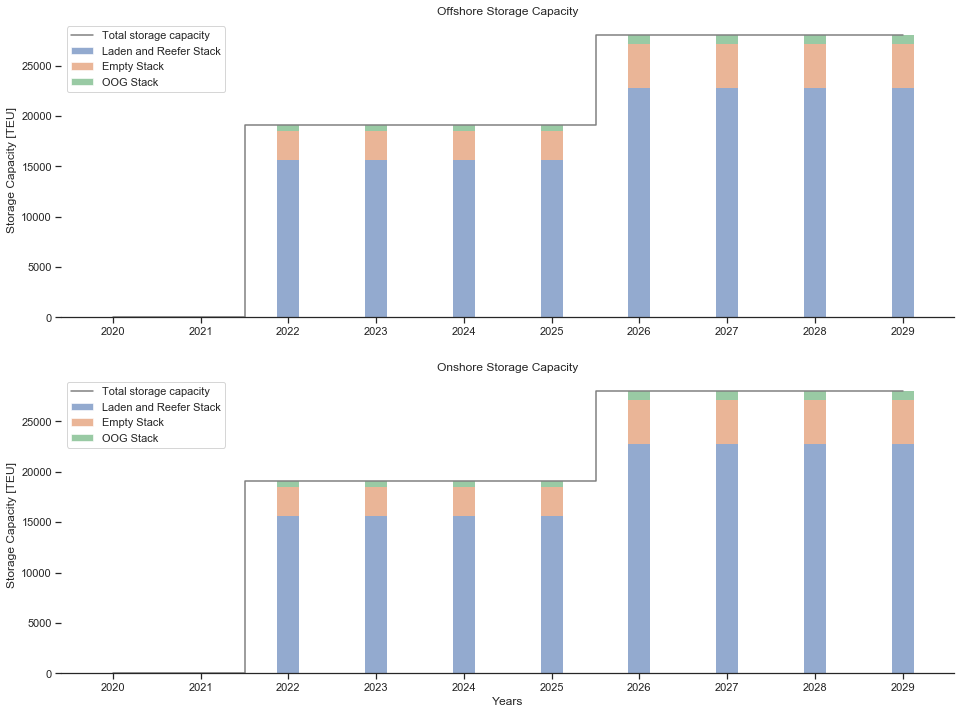

In [16]:
OffshoreBarge.storage_capacity_plot()
sns.despine(left=True)

# save fig
plt.savefig("SaveFigures/storage_area_ex2.png")

#### Add cash flow information for each of the terminal elements.

In [17]:
cash_flows_df, cash_flows_WACC_real_df = OffshoreBarge.add_cashflow_elements()
display(cash_flows_df.style.hide_index())
display(cash_flows_WACC_real_df.style.hide_index())

Year,Reclamation,Coastal Protection,Coastal Structures Maintenance,Offshore Terminal Capex,Offshore Maintenance,Offshore Insurance,Offshore Energy,Offshore Labour,Offshore Fuel,Offshore Terminal Opex,Onshore Terminal Capex,Onshore Maintenance,Onshore Insurance,Onshore Energy,Onshore Labour,Onshore Fuel,Onshore Terminal Opex,Ocean Transport,Barge Capex,Barge Opex,Capital Dredging,Maintenance Dredging
2020,4.5e+07,2.73e+08,0,4.35713e+08,0,0,0,0,0,0,7.26189e+08,0,0,0,0,0,0,0,0,0,2.6313e+08,0
2021,6.75e+07,4.095e+08,0,5.38065e+08,900000,450000,0,1.6875e+06,0,0,8.96776e+08,1.5e+06,750000,0,2.8125e+06,0,0,0,1.9e+08,0,2.6313e+08,0
2022,0,0,4.1295e+06,0,2.17678e+07,7.10351e+06,0,1.88125e+07,0,0,0,3.62796e+07,1.18392e+07,0,3.13542e+07,0,0,6e+07,0,1.9e+07,0,1.89453e+07
2023,0,0,4.1295e+06,0,2.17678e+07,7.10351e+06,0,1.88125e+07,0,0,0,3.62796e+07,1.18392e+07,0,3.13542e+07,0,0,6e+07,0,1.9e+07,0,1.89453e+07
2024,0,0,4.1295e+06,0,2.17678e+07,7.10351e+06,0,1.88125e+07,0,0,0,3.62796e+07,1.18392e+07,0,3.13542e+07,0,0,6e+07,0,1.9e+07,0,1.89453e+07
2025,0,0,4.1295e+06,4.49248e+08,2.17678e+07,7.10351e+06,0,1.88125e+07,0,0,7.48746e+08,3.62796e+07,1.18392e+07,0,3.13542e+07,0,0,9e+07,2.45e+08,1.9e+07,0,1.89453e+07
2026,0,0,4.1295e+06,2.40561e+08,2.86703e+07,7.65351e+06,0,2.525e+07,0,0,4.00936e+08,4.77839e+07,1.27558e+07,0,4.20833e+07,0,0,9e+07,0,4.35e+07,0,1.89453e+07
2027,0,0,4.1295e+06,0,3.40881e+07,1.27013e+07,0,2.9125e+07,0,0,0,5.68135e+07,2.11688e+07,0,4.85417e+07,0,0,9e+07,0,4.35e+07,0,1.89453e+07
2028,0,0,4.1295e+06,0,3.40881e+07,1.27013e+07,0,2.9125e+07,0,0,0,5.68135e+07,2.11688e+07,0,4.85417e+07,0,0,9e+07,0,4.35e+07,0,1.89453e+07
2029,0,0,4.1295e+06,0,3.40881e+07,1.27013e+07,0,2.9125e+07,0,0,0,5.68135e+07,2.11688e+07,0,4.85417e+07,0,0,9e+07,0,4.35e+07,0,1.89453e+07


Year,Reclamation,Coastal Protection,Coastal Structures Maintenance,Offshore Terminal Capex,Offshore Maintenance,Offshore Insurance,Offshore Energy,Offshore Labour,Offshore Fuel,Offshore Terminal Opex,Onshore Terminal Capex,Onshore Maintenance,Onshore Insurance,Onshore Energy,Onshore Labour,Onshore Fuel,Onshore Terminal Opex,Ocean Transport,Barge Capex,Barge Opex,Capital Dredging,Maintenance Dredging
2020,4.5e+07,2.73e+08,0,4.35713e+08,0,0,0,0,0,0,7.26189e+08,0,0,0,0,0,0,0,0,0,2.6313e+08,0
2021,6.36557e+07,3.86178e+08,0,5.07421e+08,848743,424371,0,1.59139e+06,0,0,8.45702e+08,1.41457e+06,707286,0,2.65232e+06,0,0,0,1.79179e+08,0,2.48144e+08,0
2022,0,0,3.67252e+06,0,1.93589e+07,6.31742e+06,0,1.67307e+07,0,0,0,3.22649e+07,1.0529e+07,0,2.78845e+07,0,0,4.69152e+07,0,1.68974e+07,0,1.68488e+07
2023,0,0,3.46336e+06,0,1.82564e+07,5.95763e+06,0,1.57778e+07,0,0,0,3.04273e+07,9.92938e+06,0,2.62964e+07,0,0,4.12043e+07,0,1.59351e+07,0,1.58892e+07
2024,0,0,3.26611e+06,0,1.72166e+07,5.61832e+06,0,1.48792e+07,0,0,0,2.86944e+07,9.36387e+06,0,2.47987e+07,0,0,3.59916e+07,0,1.50275e+07,0,1.49843e+07
2025,0,0,3.0801e+06,3.35084e+08,1.62361e+07,5.29835e+06,0,1.40318e+07,0,0,5.58473e+08,2.70602e+07,8.83058e+06,0,2.33864e+07,0,0,5.36154e+07,1.8274e+08,1.41717e+07,0,1.41309e+07
2026,0,0,2.90468e+06,1.6921e+08,2.01666e+07,5.38346e+06,0,1.77608e+07,0,0,2.82017e+08,3.36111e+07,8.97243e+06,0,2.96013e+07,0,0,4.67387e+07,0,3.05978e+07,0,1.33261e+07
2027,0,0,2.73925e+06,0,2.26119e+07,8.42524e+06,0,1.93197e+07,0,0,0,3.76865e+07,1.40421e+07,0,3.21995e+07,0,0,4.04714e+07,0,2.88552e+07,0,1.25671e+07
2028,0,0,2.58324e+06,0,2.13241e+07,7.9454e+06,0,1.82194e+07,0,0,0,3.55402e+07,1.32423e+07,0,3.03657e+07,0,0,3.47663e+07,0,2.72118e+07,0,1.18514e+07
2029,0,0,2.43612e+06,0,2.01096e+07,7.49289e+06,0,1.71817e+07,0,0,0,3.35161e+07,1.24882e+07,0,2.86362e+07,0,0,2.95798e+07,0,2.5662e+07,0,1.11764e+07


In [18]:
PV, PV_df = OffshoreBarge.net_present_value()

,Years,Capex,Opex,PV,cum-PV
0,2020,-3.180000e+08,-6.988427e+08,-1.016843e+09,-1.016843e+09
1,2021,-4.498336e+08,-9.376084e+08,-1.387442e+09,-2.404285e+09
2,2022,-3.672522e+06,-1.230685e+08,-1.267410e+08,-2.531026e+09
3,2023,-3.463362e+06,-1.130204e+08,-1.164837e+08,-2.647509e+09
4,2024,-3.266115e+06,-1.037176e+08,-1.069838e+08,-2.754493e+09
5,2025,-3.080101e+06,-6.353078e+08,-6.383879e+08,-3.392881e+09
6,2026,-2.904681e+06,-3.031839e+08,-3.060886e+08,-3.698970e+09
7,2027,-2.739252e+06,-1.322506e+08,-1.349898e+08,-3.833959e+09
8,2028,-2.583244e+06,-1.213184e+08,-1.239017e+08,-3.957861e+09
9,2029,-2.436121e+06,-1.112026e+08,-1.136387e+08,-4.071500e+09


In [19]:
# OffshoreBarge.terminal_opex_plot(cash_flows_df)
# sns.despine(left=True)

In [20]:
hide_columns_list = ['Offshore Maintenance', 'Offshore Insurance', 'Offshore Energy', 
                     'Offshore Labour', 'Offshore Fuel', 'Offshore Demurrage',
                     'Onshore Maintenance', 'Onshore Insurance', 'Onshore Energy', 
                     'Onshore Labour', 'Onshore Fuel', 'Onshore Demurrage', 'revenues']
cash_flows_WACC_real_df.style.hide_columns(hide_columns_list).hide_index()

Year,Reclamation,Coastal Protection,Coastal Structures Maintenance,Offshore Terminal Capex,Offshore Terminal Opex,Onshore Terminal Capex,Onshore Terminal Opex,Ocean Transport,Barge Capex,Barge Opex,Capital Dredging,Maintenance Dredging
2020,4.5e+07,2.73e+08,0,4.35713e+08,0,7.26189e+08,0,0,0,0,2.6313e+08,0
2021,6.36557e+07,3.86178e+08,0,5.07421e+08,0,8.45702e+08,0,0,1.79179e+08,0,2.48144e+08,0
2022,0,0,3.67252e+06,0,0,0,0,4.69152e+07,0,1.68974e+07,0,1.68488e+07
2023,0,0,3.46336e+06,0,0,0,0,4.12043e+07,0,1.59351e+07,0,1.58892e+07
2024,0,0,3.26611e+06,0,0,0,0,3.59916e+07,0,1.50275e+07,0,1.49843e+07
2025,0,0,3.0801e+06,3.35084e+08,0,5.58473e+08,0,5.36154e+07,1.8274e+08,1.41717e+07,0,1.41309e+07
2026,0,0,2.90468e+06,1.6921e+08,0,2.82017e+08,0,4.67387e+07,0,3.05978e+07,0,1.33261e+07
2027,0,0,2.73925e+06,0,0,0,0,4.04714e+07,0,2.88552e+07,0,1.25671e+07
2028,0,0,2.58324e+06,0,0,0,0,3.47663e+07,0,2.72118e+07,0,1.18514e+07
2029,0,0,2.43612e+06,0,0,0,0,2.95798e+07,0,2.5662e+07,0,1.11764e+07


In [21]:
print('\033[1m    Cost Estimate\033[0m')
print(' ** PV of the costs: ${}'.format(f'{round(PV,-6):,}'))

    Cost Estimate
 ** PV of the costs: $-4,071,000,000.0


 Cash Flow Plot - Weighted average cost of capital 


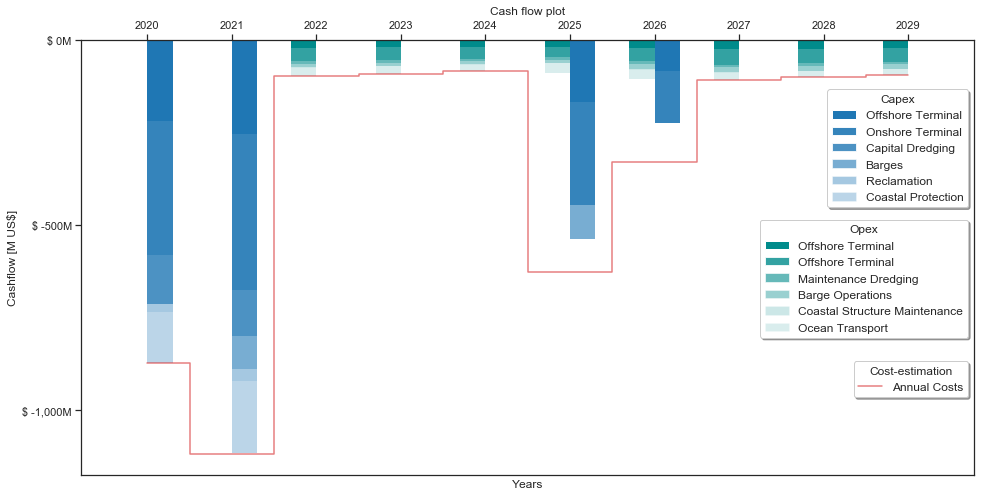

In [22]:
print('\033[1m Cash Flow Plot - Weighted average cost of capital \033[0m')
OffshoreBarge.cashflow_plot(cash_flows_WACC_real_df)

# save fig
if lifecycle == 10:
    plt.savefig("SaveFigures/cash_flow_plot_WACC_alt2.png", bbox_inches = 'tight')

In [23]:
# OffshoreBarge.element_cashflow_plot()

In [24]:
print("Offshore terminal capacity for initial demand:")
total_offshore_ground_slots, total_offshore_stack_capacity, total_offshore_stack_online = OffshoreBarge.total_stack_capacity(2023)

total_offshore_ground_slots = round(total_offshore_ground_slots,-1)
total_offshore_stack_capacity = round(total_offshore_stack_capacity,-1)
      
%store total_offshore_ground_slots
%store total_offshore_stack_capacity

Offshore terminal capacity for initial demand:
     Total Ground Slots required   (@ start of year):  3,438
     Total Stack capacity required (@ start of year):  18,200 TEU
     Total Stack capacity online   (@ start of year):  19,100 TEU

Stored 'total_offshore_ground_slots' (float)
Stored 'total_offshore_stack_capacity' (int)


### Example figures

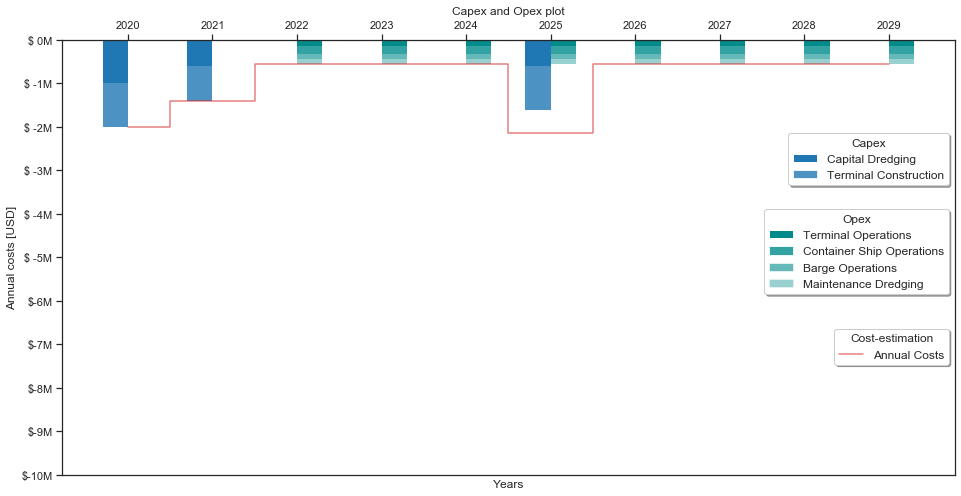

In [25]:
OffshoreBarge.ex_cashflow_plot(cash_flows_df)

# save fig
if lifecycle == 10:
    plt.savefig("SaveFigures/ex_cashflow_plot.png", bbox_inches = 'tight')

In [26]:
demand = annual_demand.value

if demand == 1000000:
    if offshore_distance == 20:  
        if design_container_ship == 6000:
            PV_alt2_20_6000_1000000 = PV
            %store PV_alt2_20_6000_1000000

        if design_container_ship == 12500:
            PV_alt2_20_12500_1000000 = PV
            %store PV_alt2_20_12500_1000000

        if design_container_ship == 21000:
            PV_alt2_20_21000_1000000 = PV
            %store PV_alt2_20_21000_1000000

    if offshore_distance == 40:  
        if design_container_ship == 6000:
            PV_alt2_40_6000_1000000 = PV
            %store PV_alt2_40_6000_1000000

        if design_container_ship == 12500:
            PV_alt2_40_12500_1000000 = PV
            %store PV_alt2_40_12500_1000000

        if design_container_ship == 21000:
            PV_alt2_40_21000_1000000 = PV
            %store PV_alt2_40_21000_1000000

    if offshore_distance == 60:  
        if design_container_ship == 6000:
            PV_alt2_60_6000_1000000 = PV
            %store PV_alt2_60_6000_1000000

        if design_container_ship == 12500:
            PV_alt2_60_12500_1000000 = PV
            %store PV_alt2_60_12500_1000000

        if design_container_ship == 21000:
            PV_alt2_60_21000_1000000 = PV
            %store PV_alt2_60_21000_1000000

Stored 'PV_alt2_40_12500_1000000' (float64)
